## Finite precover decompositions

In [38]:
from collections import deque
from transduction.fst import FST, eps

A nice machine is given below

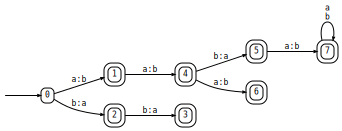

In [39]:
fst = FST()
fst.add_arc(0,"a","b",1)
fst.add_arc(0,"b","a",2)
fst.add_arc(2,"b", "a", 3)

fst.add_arc(1,"a","b", 4)
fst.add_arc(4, "b","a", 5)
fst.add_arc(4,"a","b",6)
fst.add_arc(5, "a", "b", 7)
fst.add_arc(7,"a","a",7)
fst.add_arc(7,"b","b",7)

fst.I.add(0)
fst.F.update({1,2,3,4,5,6,7})
display(fst)

### Conditions for finite cover

1. No epsilon output loops

2. Every state reachable by scanning input has no input scanning cycles on the path to the state and the state either has finite closure or is universal.

TODO: make this exact

#### No epsilon output loop check

In [40]:
# strictly speaking we should ignore loops where there is no
# scanned input but we assume there are no such loops


def _has_eps_cycle(fst, i, visited, recursion_stack):
    visited.add(i)
    recursion_stack.add(i)
    for _, b, j in fst.arcs(i):
        if b != eps:
            continue
        if j not in visited:
            if _has_eps_cycle(fst, j, visited, recursion_stack):
                return True
        elif j in recursion_stack:
            return True
    recursion_stack.remove(i)
    return False


def has_eps_cycle(fst):
    for state in fst.states:
        if _has_eps_cycle(fst, state, set(), set()):
            return True
    return False



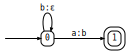

In [41]:
fst_c = FST()
fst_c.add_arc(0,"a","b",1)
fst_c.add_arc(0,"b",eps,0)
fst_c.I.add(0)
fst_c.F.add(1)
display(fst_c)

In [42]:
has_eps_cycle(fst_c)


True

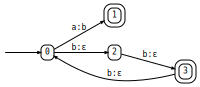

In [43]:
fst_c = FST()
fst_c.add_arc(0,"a","b",1)
fst_c.add_arc(0,"b",eps,2)
fst_c.add_arc(2,"b",eps,3)
fst_c.add_arc(3,"b",eps,0)

fst_c.I.add(0)
fst_c.F.add(1)
fst_c.F.add(3)
display(fst_c)

In [44]:
has_eps_cycle(fst_c)


True

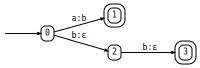

In [45]:
fst_nc = FST()
fst_nc.add_arc(0,"a","b",1)
fst_nc.add_arc(0,"b",eps,2)
fst_nc.add_arc(2,"b",eps,3)
fst_nc.I.add(0)
fst_nc.F.add(1)
fst_nc.F.add(3)
display(fst_nc)
fst_no_cycle = fst_nc

In [46]:
has_eps_cycle(fst_nc)


False

In [47]:
has_eps_cycle(fst)

False

#### Universality check

In [48]:
def is_universal(fst, i):
    # same as on class
    i_fst = fst.spawn(keep_arcs=True, keep_stop=True)
    i_fst.add_I(i)
    i_fsa = i_fst.project(0)
    i_dfa = i_fsa.min()
    if len(i_dfa.states) != 1:
        return False
    [i] = i_dfa.states
    for a in fst.A:
        if set(i_dfa.arcs(i, a)) != {i}:
            return False
    return True


In [49]:
for i in fst_nc.states:
    print(i, is_universal(fst_nc, i))

0 False
1 False
2 False
3 False


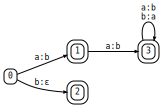

In [50]:
fst_u = FST()
fst_u.add_arc(0,"a","b",1)
fst_u.add_arc(0,"b",eps,2)
fst_u.add_arc(1, "a", "b",3)
fst_u.add_arc(3, "b", "a",3)
fst_u.add_arc(3, "a", "b",3)
fst_u.F.add(1)
fst_u.F.add(2)
fst_u.F.add(3)
display(fst_u)

In [51]:
for i in fst_u.states:
    print(i, is_universal(fst_u, i))

0 False
1 False
2 False
3 True


#### No input scanning cycles

In [52]:
def has_input_cycle(fst):
    sccs = fst.strongly_connected_components()

    comp_id = {}
    for cid, comp in enumerate(sccs):
        for q in comp:
            comp_id[q] = cid

    n = len(sccs)
    size = [len(comp) for comp in sccs]
    has_self_loop = [False] * n
    has_non_eps_arc = [False] * n

    for i in fst.states:
        cid = comp_id[i]
        for a, _, j in fst.arcs(i):
            if comp_id[j] != cid:
                continue

            if i == j:
                has_self_loop[cid] = True
            if a != eps:
                has_non_eps_arc[cid] = True

    # SCC has an input-scanning cycle if actually has a cycle and has at least one non-epsilon arc
    for cid in range(n):
        if has_non_eps_arc[cid] and (size[cid] > 1 or has_self_loop[cid]):
            return True

    return False


In [53]:
has_input_cycle(fst)


True

In [54]:
has_input_cycle(fst_nc)


False

In [55]:
def has_input_cycle_on_path(fst, path):
    first = path[0]

    if isinstance(first, tuple) and len(first) == 4:
        start_state = path[0][0]
        end_state = path[-1][3]
    else:
        start_state = path[0]
        end_state = path[-1]

    sub = fst.spawn(keep_arcs=True)
    sub.I.clear()
    sub.F.clear()
    sub.add_I(start_state)
    sub.add_F(end_state)
    trimmed = sub.trim()

    return has_input_cycle(trimmed)

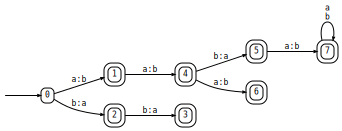

In [56]:
display(fst)


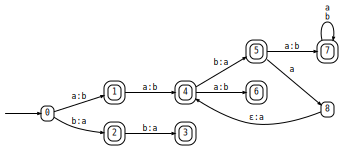

In [57]:
fst_loop = fst.spawn(keep_init=True, keep_stop=True, keep_arcs=True)
fst_loop.add_arc(5,"a","a", 8)
fst_loop.add_arc(8, eps, "a", 4)
display(fst_loop)

In [58]:
assert has_input_cycle(fst_loop)
path = [1,4,5]
assert has_input_cycle_on_path(fst_loop, path)

path = [0,2,3]
assert not has_input_cycle_on_path(fst_loop, path)

#### Finite closure check

In [59]:
def has_fc(fst, i):
    i_fst = fst.spawn(keep_arcs=True, keep_stop=True, keep_init=False)
    i_fst.add_I(i)
    i_fst = i_fst.trim()
    return not has_input_cycle(i_fst)


In [60]:
for i in [1,4,5,7]:
   assert not has_fc(fst_loop, i)

for i in [2, 3, 6]:
    assert has_fc(fst_loop, i)

#### Getting the emitting paths

In [61]:
def paths_emitting(fst, y, max_paths=None, only_final=False):
    paths = []

    def dfs(state, pos, path, seen):
        if pos == len(y):
            if not only_final or fst.is_final(state):
                paths.append(list(path))
                if max_paths is not None and len(paths) >= max_paths:
                    return

        if max_paths is not None and len(paths) >= max_paths:
            return

        for a, b, j in fst.arcs(state):
            next_pos = pos

            if b == eps:
                pass
            else:
                if pos >= len(y) or b != y[pos]:
                    continue
                next_pos += 1

            key = (j, next_pos)
            if key in seen:
                continue

            seen.add(key)
            path.append((state, a, b, j))
            dfs(j, next_pos, path, seen)
            path.pop()
            seen.remove(key)

    for i in fst.I:
        seen = {(i, 0)}
        dfs(i, 0, [], seen)

    return paths


In [62]:
paths_emitting(fst, "bba")

[[(0, 'a', 'b', 1), (1, 'a', 'b', 4), (4, 'b', 'a', 5)]]

#### Check if state is safe

In [63]:
from functools import lru_cache, wraps

def lru_cache_sets(maxsize=None):
    def decorator(func):
        @lru_cache(maxsize=maxsize)
        def cached(fst, i, frozen_arg):
            return func(fst, i, set(frozen_arg))

        @wraps(func)
        def wrapper(fst, i, s):
            return cached(fst, i, frozenset(s))

        return wrapper
    return decorator


#@lru_cache_sets(maxsize=None)
def check_safe(fst, i, visited):
    if is_universal(fst, i):
        return True
    
    if has_fc(fst, i):
        return True
 
    tgts_safe = []
    arcs = fst.arcs(i)
    for _, _, j in fst.arcs(i):
        if j in visited:
            return False
        visited.add(j)
        tgts_safe.append(check_safe(fst, j, visited))
    return all(tgts_safe)

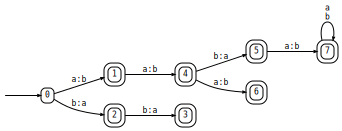

In [64]:
fst

In [65]:
for i in fst.states:
   visited = set()
   print(i, check_safe(fst, i, visited))

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True


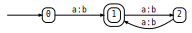

In [66]:
# machine with infinite remainder for a
fst_ir = FST()
fst_ir.add_arc(0,"a","b",1)
fst_ir.add_arc(1,"a","b",2)
fst_ir.add_arc(2,"a", "b",1)
fst_ir.I.add(0)
fst_ir.F.add(1)
display(fst_ir)


In [67]:
for i in fst_ir.states:
   print(i, check_safe(fst_ir, i, set()))


0 False
1 False
2 False


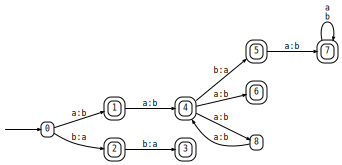

In [68]:
fst_mod = fst.spawn(keep_arcs=True, keep_init=True, keep_stop=True)
fst_mod.add_arc(4,"a","b",8)
fst_mod.add_arc(8,"a","b",4)
fst_mod

In [69]:
for i in fst_mod.states:
   print(i, check_safe(fst_mod, i, set()))

0 False
1 False
2 True
3 True
4 False
5 True
6 True
7 True
8 False


### Check epsilon loops on target

In [82]:
def check_epsilon_loops_tgt(fst, y):
    # Check epsilon loops
    paths = paths_emitting(fst, y)
    for path in paths:
        final_state = path[-1][-1]
        fst_i = fst.spawn(keep_arcs=True, keep_init=False, keep_stop=True)
        fst_i.add_I(final_state)
        fst_i = fst_i.trim()
        has_eps_loop = has_eps_cycle(fst_i)
        if has_eps_loop:
            return True
    return False

In [83]:
check_epsilon_loops_tgt(fst, "bba")

False

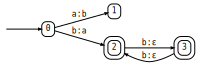

In [84]:
fst_e = FST()
fst_e.add_arc(0,"a","b",1)
fst_e.add_arc(0,"b","a",2)
fst_e.add_arc(2,"b",eps,3)
fst_e.add_arc(3,"b",eps,2)

fst_e.I.add(0)
fst_e.F.add(2)
fst_e.F.add(3)
display(fst_e)

In [85]:
assert not check_epsilon_loops_tgt(fst_e, "b")
assert check_epsilon_loops_tgt(fst_e, "a")

### Checking for finite decomposition

In [ ]:
def check_finite_precover_decomp(fst, y):

    assert not check_epsilon_loops_tgt(fst, y), "Has epsilon loop"

    paths = paths_emitting(fst, y)
    assert len(paths) < 9999, "To many paths?"

    for path in paths:
        end = path[-1][-1]
        assert check_safe(fst, end)

    return True



In [87]:
check_finite_precover_decomp(fst, "bb")

TypeError: check_safe() missing 1 required positional argument: 'visited'